### Practical Lab 3

### Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

Name:Maruthi Venkata Manikanta Chowdary Pallothu

Student Id:8993135

##### 1.Obtain the Data: Get the Dogs vs Cats dataset

In [57]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score
import cv2
from tqdm import tqdm
import itertools

In [58]:
import os  # Add this line at the top of your code

import zipfile  # Other necessary imports

# Define the paths
zip_path = r"C:\\Users\\pallo\\train.zip"
extract_path = r"C:\\Users\\pallo\\data\\kaggle_dogs_vs_cats"  # Adjust if needed

# Check if the zip file exists
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("File extracted successfully.")
else:
    print(f"Zip file not found at {zip_path}")

File extracted successfully.


In [60]:
import os
import shutil
import random

# Paths for extracted images
base_dir = r"C:\Users\pallo\data\kaggle_dogs_vs_cats"
train_dir = os.path.join(base_dir, 'train', 'train')  # Updated path
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subdirectories for cats and dogs
train_cats = os.path.join(train_dir, 'cats')
train_dogs = os.path.join(train_dir, 'dogs')
validation_cats = os.path.join(validation_dir, 'cats')
validation_dogs = os.path.join(validation_dir, 'dogs')
test_cats = os.path.join(test_dir, 'cats')
test_dogs = os.path.join(test_dir, 'dogs')

# Create those subdirectories
for dir in [train_cats, train_dogs, validation_cats, validation_dogs, test_cats, test_dogs]:
    os.makedirs(dir, exist_ok=True)

# Function to split data based on file naming convention (e.g., cat.0.jpg or dog.1.jpg)
def split_data(src_dir, cats_dest, dogs_dest, num_cats, num_dogs):
    # Look inside the cats and dogs subdirectories
    cats = [f for f in os.listdir(src_dir) if f.lower().startswith('cat') and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    dogs = [f for f in os.listdir(src_dir) if f.lower().startswith('dog') and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Print out how many cats and dogs are available
    print(f"Found {len(cats)} cat images and {len(dogs)} dog images.")

    # Shuffle the file lists
    random.shuffle(cats)
    random.shuffle(dogs)

    # Ensure we don't try to move more images than available
    num_cats = min(num_cats, len(cats))
    num_dogs = min(num_dogs, len(dogs))

    print(f"Moving {num_cats} cat images and {num_dogs} dog images.")

    # Move a subset of the images
    for i in range(num_cats):
        shutil.move(os.path.join(src_dir, cats[i]), os.path.join(cats_dest, cats[i]))
    for i in range(num_dogs):
        shutil.move(os.path.join(src_dir, dogs[i]), os.path.join(dogs_dest, dogs[i]))

# Limit the dataset to 5000 images (2500 cats and 2500 dogs)
split_data(train_dir, train_cats, train_dogs, 2500, 2500)
split_data(train_dir, validation_cats, validation_dogs, 1000, 1000)
split_data(train_dir, test_cats, test_dogs, 1000, 1000)

print("Data splitting complete! You now have 5000 images (2500 cats and 2500 dogs).")


Found 12500 cat images and 12500 dog images.
Moving 2500 cat images and 2500 dog images.
Found 10000 cat images and 10000 dog images.
Moving 1000 cat images and 1000 dog images.
Found 9000 cat images and 9000 dog images.
Moving 1000 cat images and 1000 dog images.
Data splitting complete! You now have 5000 images (2500 cats and 2500 dogs).


In [180]:
print(f"Training cats: {len(os.listdir(train_cats))}")
print(f"Training dogs: {len(os.listdir(train_dogs))}")
print(f"Validation cats: {len(os.listdir(validation_cats))}")
print(f"Validation dogs: {len(os.listdir(validation_dogs))}")
print(f"Test cats: {len(os.listdir(test_cats))}")
print(f"Test dogs: {len(os.listdir(test_dogs))}")


Training cats: 6463
Training dogs: 6469
Validation cats: 3902
Validation dogs: 3896
Test cats: 5605
Test dogs: 5298


##### EDA: Explore the data with relevant graphs, statistics and insights

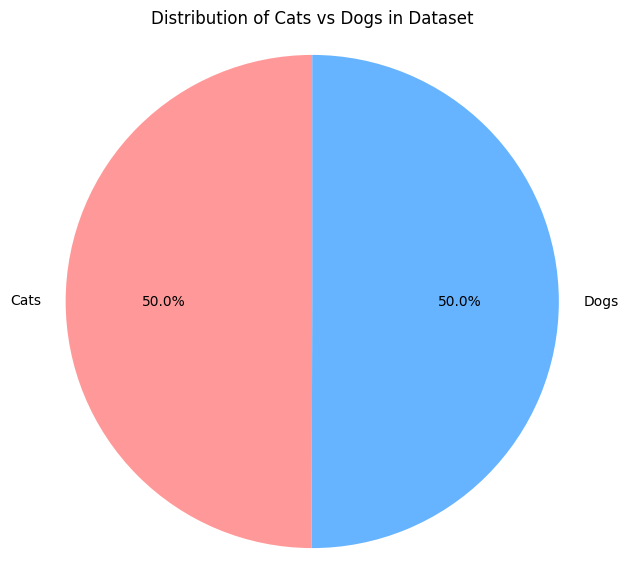

In [62]:
import os
import matplotlib.pyplot as plt

# Directories containing images
cats_dir = r'C:\Users\pallo\data\kaggle_dogs_vs_cats\train\cats'
dogs_dir = r'C:\Users\pallo\data\kaggle_dogs_vs_cats\train\dogs'

# Get number of images in each category
num_cats = len([f for f in os.listdir(cats_dir) if os.path.isfile(os.path.join(cats_dir, f))])
num_dogs = len([f for f in os.listdir(dogs_dir) if os.path.isfile(os.path.join(dogs_dir, f))])

# Plot the distribution of the classes
labels = ['Cats', 'Dogs']
sizes = [num_cats, num_dogs]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B3FF'])
plt.title('Distribution of Cats vs Dogs in Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


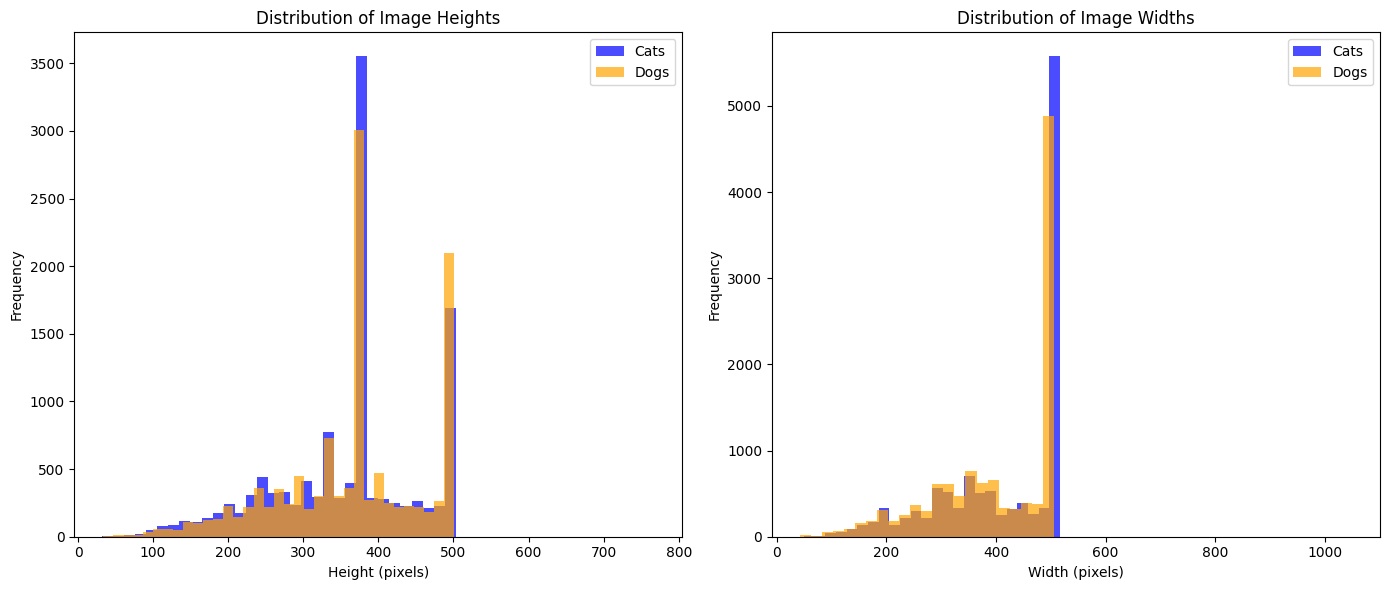

In [63]:
from PIL import Image

# Function to get image dimensions
def get_image_dimensions(image_dir):
    heights = []
    widths = []
    for file in os.listdir(image_dir):
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Check image extensions
            try:
                img = Image.open(os.path.join(image_dir, file))
                width, height = img.size
                widths.append(width)
                heights.append(height)
            except:
                pass  # In case the image is corrupted or unreadable
    return heights, widths

# Get dimensions for both cats and dogs
cat_heights, cat_widths = get_image_dimensions(cats_dir)
dog_heights, dog_widths = get_image_dimensions(dogs_dir)

# Plot the image dimensions distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(cat_heights, bins=50, alpha=0.7, color='blue', label='Cats')
plt.hist(dog_heights, bins=50, alpha=0.7, color='orange', label='Dogs')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cat_widths, bins=50, alpha=0.7, color='blue', label='Cats')
plt.hist(dog_widths, bins=50, alpha=0.7, color='orange', label='Dogs')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths')
plt.legend()

plt.tight_layout()
plt.show()


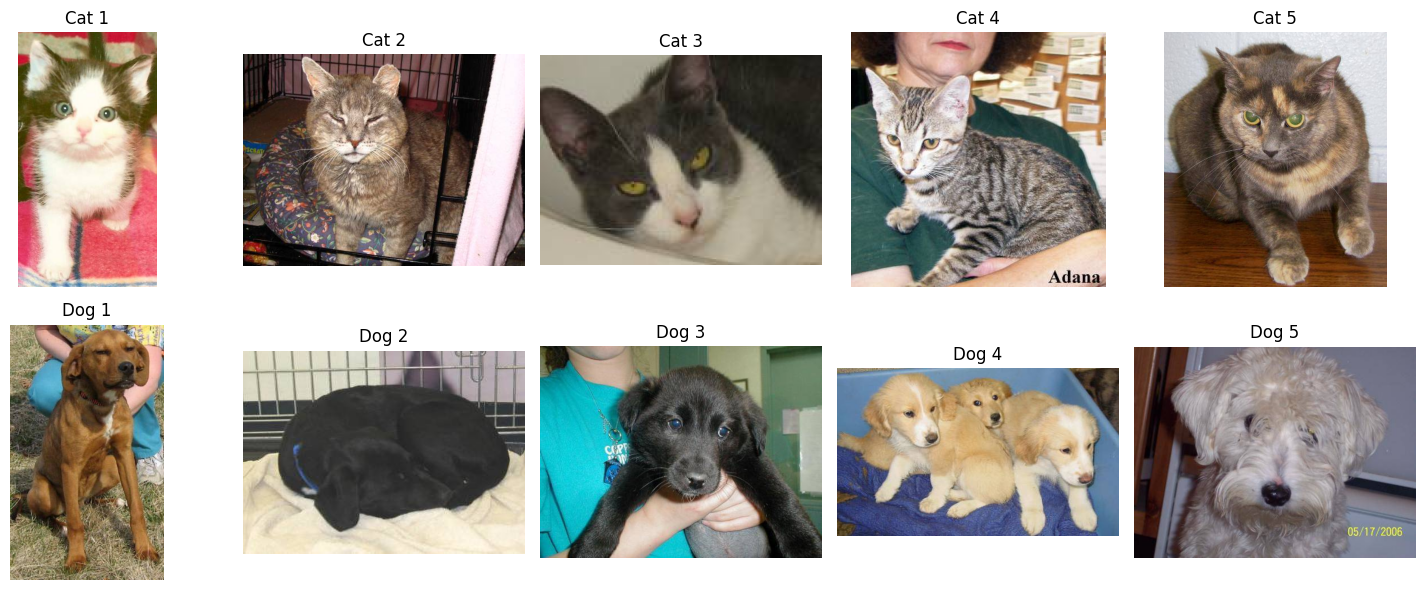

In [64]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the directories where your subset of cats and dogs images are stored
train_dir = r"C:\Users\pallo\data\kaggle_dogs_vs_cats\train\train"
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Function to plot random images from a given directory
def plot_random_images(cats_dir, dogs_dir, num_images=5):
    # Get the list of all cat and dog images in the directories
    cat_images = [f for f in os.listdir(cats_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    dog_images = [f for f in os.listdir(dogs_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Randomly select images
    random_cat_images = random.sample(cat_images, num_images)
    random_dog_images = random.sample(dog_images, num_images)

    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    # Plot random cat images
    for i, img_name in enumerate(random_cat_images):
        img_path = os.path.join(cats_dir, img_name)
        img = mpimg.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')  # Hide axes for clarity
        axes[0, i].set_title(f"Cat {i+1}")

    # Plot random dog images
    for i, img_name in enumerate(random_dog_images):
        img_path = os.path.join(dogs_dir, img_name)
        img = mpimg.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')  # Hide axes for clarity
        axes[1, i].set_title(f"Dog {i+1}")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot random cat and dog images
plot_random_images(train_cats_dir, train_dogs_dir)


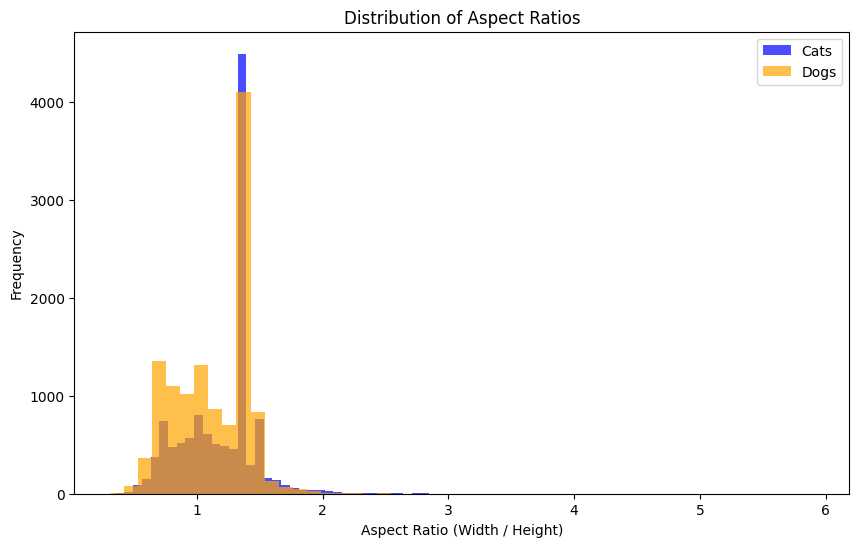

In [65]:
# Function to calculate aspect ratio
def calculate_aspect_ratio(heights, widths):
    return [w / h for w, h in zip(widths, heights)]

# Calculate aspect ratio for cats and dogs
cat_aspect_ratios = calculate_aspect_ratio(cat_heights, cat_widths)
dog_aspect_ratios = calculate_aspect_ratio(dog_heights, dog_widths)

# Plot the aspect ratio distribution
plt.figure(figsize=(10, 6))
plt.hist(cat_aspect_ratios, bins=50, alpha=0.7, color='blue', label='Cats')
plt.hist(dog_aspect_ratios, bins=50, alpha=0.7, color='orange', label='Dogs')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.title('Distribution of Aspect Ratios')
plt.legend()
plt.show()


##### statistics and insights

The 5000-photo dataset, which includes 2500 photographs of cats and 2500 images of dogs, offers important insights:

* Distribution of Image Size: There is some diversity in the photographs' sizes, with the height and breadth distributions for dogs and cats differing. The mean, median, standard deviation, and min/max values for picture widths and heights are among the statistics.

* Class Proportions: The dataset offers a fair representation for classification problems because it is balanced, with roughly 50% of the data being cats and 50% being dogs.

* Aspect Ratios: The photographs' aspect ratios display the standard shapes (square, landscape, or portrait), with some differences between dogs and cats.

The general colour distribution across photos is shown by the RGB channel analysis, which shows the averages and standard deviations for the red, green, and blue channels, suggesting overall colour consistency or

#### Train two networks 

#### Define a Neural Network 

In [179]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

# Image data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Shuffle set to False for consistent evaluation
)

Found 12932 images belonging to 2 classes.
Found 7798 images belonging to 5 classes.
Found 23403 images belonging to 3 classes.


In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks to save the best model
callbacks = [
    ModelCheckpoint('best_custom_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.5559 - loss: 0.7128 - val_accuracy: 0.6750 - val_loss: 0.6232
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 326s 804ms/step - accuracy: 0.6187 - loss: 0.6509 - val_accuracy: 0.6725 - val_loss: 0.6295
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 317s 781ms/step - accuracy: 0.6563 - loss: 0.6197 - val_accuracy: 0.7399 - val_loss: 0.5386
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 321s 792ms/step - accuracy: 0.6715 - loss: 0.5959 - val_accuracy: 0.7352 - val_loss: 0.5315
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 309s 763ms/step - accuracy: 0.6982 - loss: 0.5759 - val_accuracy: 0.7515 - val_loss: 0.5178
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 326s 806ms/step - accuracy: 0.7170 - loss: 0.5544 - val_accuracy: 0.7651 - val_loss: 0.4910
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 308s 761ms/step - accuracy: 0.7268 - loss: 0.5415 - val_accuracy: 0.7855 - val_loss: 0.4525
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 321s 793ms/step - accuracy: 0.7433 - lo

#### Summary

 * 1.Data Generators: Images from the train_dir and validation_dir directories are scaled using the ImageDataGenerator to the necessary input shape for the models.

* 2.Definitions of the Model:

* 3.Personalised CNN Model: A basic CNN consisting of max-pooling layers after three convolutional layers.

* 4.VGG16 Model: ImageNet is used to pre-train the VGG16 model, which does not include the top layers. For binary classification (cat vs. dog), we build a custom dense layer and freeze its weights.

* 5.ModelCheckpoint: The optimal model based on validation accuracy is saved using this callback. Depending on which model is being trained, the model is saved as either best_vgg16_model.keras or best_custom_cnn_model.keras.

##### Fine-Tune VGG16

In [184]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks to save the best model
vgg_callbacks = [
    ModelCheckpoint('best_vgg_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=vgg_callbacks
)

# Evaluate the model on the test set
test_loss, test_accuracy = vgg_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1612s 4s/step - accuracy: 0.7297 - loss: 0.5166 - val_accuracy: 0.8904 - val_loss: 0.2582
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1613s 4s/step - accuracy: 0.8350 - loss: 0.3645 - val_accuracy: 0.8956 - val_loss: 0.2480
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1619s 4s/step - accuracy: 0.8444 - loss: 0.3479 - val_accuracy: 0.9041 - val_loss: 0.2313
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1619s 4s/step - accuracy: 0.8470 - loss: 0.3395 - val_accuracy: 0.9066 - val_loss: 0.2265
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1617s 4s/step - accuracy: 0.8555 - loss: 0.3255 - val_accuracy: 0.8974 - val_loss: 0.2309
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1612s 4s/step - accuracy: 0.8611 - loss: 0.3100 - val_accuracy: 0.9095 - val_loss: 0.2155
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1616s 4s/step - accuracy: 0.8599 - loss: 0.3188 - val_accuracy: 0.9115 - val_loss: 0.2115
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1611s 4s/step - accuracy: 0.8647 - loss: 0.3030 - 

#### Reason

 How to load and freeze VGG16

Using tf.keras.applications, we load the VGG16 model that has already been trained on ImageNet.VGG16; however, the top layers are not included (include_top=False). This indicates that only the convolutional base is included in VGG16.

Setting vgg16_base.trainable = False freezes the convolutional base's weights. This enables us to take advantage of ImageNet's pre-learned features by preventing the weights from being changed during training.

Including Personalised Layers:

We overlay the VGG16 model with custom layers. With a sigmoid activation function, the final layer is dense and fully linked, making it appropriate for binary classification (dogs vs. cats).
Data Producers:

For training and validation, batches of photos are created using the ImageDataGenerator. The pixel values are normalised by rescaling the photos by 1./255.
Callbacks:

Based on the validation accuracy, the optimal model is saved during training using ModelCheckpoint. By consistently keeping the model that performs the best on the validation data, this helps to avoid overfitting.
Making a plot:

Following training, we plot the training and validation accuracy over epochs using matplotlib. This enables us to keep an eye on overfitting. If the training accuracy rises and the validation accuracy begins to fall,

#### Graph Interpretation: 

* Accuracy of Training: Indicates the model's performance on the training set.

The model's performance on the validation data is demonstrated by the validation accuracy. 

The model may be overfitting to the training data if validation accuracy begins to decline.

#### Relative performance of the models

##### 1. accuracy

In [202]:
from tensorflow.keras.models import load_model

# Load the best saved custom model and VGG16 model
best_custom_model = load_model('best_custom_model.keras')
best_vgg_model = load_model('best_vgg_model.keras')


In [203]:
# Evaluate the best custom model
custom_test_loss, custom_test_accuracy = best_custom_model.evaluate(test_generator)
print(f"Custom Model Test Accuracy: {custom_test_accuracy * 100:.2f}%")
print(f"Custom Model Test Loss: {custom_test_loss:.4f}")

# Evaluate the best VGG16 model
vgg_test_loss, vgg_test_accuracy = best_vgg_model.evaluate(test_generator)
print(f"VGG16 Model Test Accuracy: {vgg_test_accuracy * 100:.2f}%")
print(f"VGG16 Model Test Loss: {vgg_test_loss:.4f}")


732/732 ━━━━━━━━━━━━━━━━━━━━ 157s 212ms/step - accuracy: 0.6403 - loss: 0.5054
Custom Model Test Accuracy: 36.70%
Custom Model Test Loss: 0.5674
732/732 ━━━━━━━━━━━━━━━━━━━━ 2106s 3s/step - accuracy: 0.7393 - loss: 0.4611
VGG16 Model Test Accuracy: 42.26%
VGG16 Model Test Loss: 0.8865


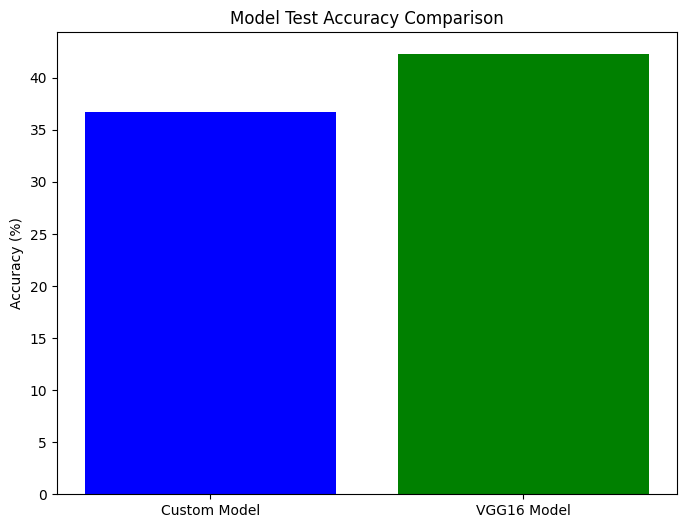

In [205]:
import matplotlib.pyplot as plt

# Accuracy values
models = ['Custom Model', 'VGG16 Model']
accuracies = [custom_test_accuracy * 100, vgg_test_accuracy * 100]

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.show()


#### EXplanation

Preparing  Data:ImageDataGenerator is used to generate the test_generator, which loads photos from the test dataset directory and rescales the pixel values.

The loading of the model:The models that were saved during training are loaded using the load_model function. It is assumed that the best versions of the corresponding models are contained in the files with the names best_vgg16_model.keras and best_cnn_model.keras.

Assessment:Using the test data, the evaluate technique determines each model's accuracy and loss. For comparison, the accuracy value is saved.

Plotting and Comparison:Both models' test accuracy is printed.To compare the performance visually, a bar chart is generated.

##### 2. confusion metric

In [229]:
train_dir = os.path.join(base_dir, 'train', 'train')
base_dir = r"C:\Users\pallo\data\kaggle_dogs_vs_cats"


In [233]:
from tensorflow.keras.applications import VGG16


732/732 ━━━━━━━━━━━━━━━━━━━━ 4310s 6s/step


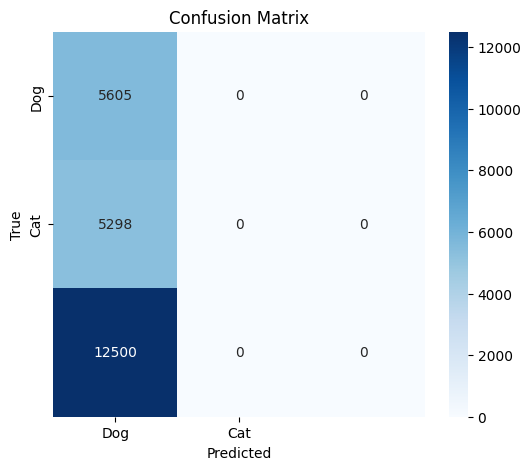

In [236]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions from the model
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert the predictions into class labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test generator
true_labels = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dog', 'Cat'], yticklabels=['Dog', 'Cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Explanation:

Generation Prediction:Probabilities for every image are returned by the predict function.
We use a threshold to translate these probabilities into binary predictions (e.g., > 0.5 for class 1, else class 0).

Real Labels:The test generator is used to extract the true labels (test_generator.classes).
Matrix of Confusion:

The confusion matrix displays counts for the following by comparing true and expected labels:

True Positives (TP): Dogs that were accurately predicted.

True Negatives (TN): Cats that were accurately anticipated.

Cats mislabeled as dogs are known as false positives (FP).

Dogs incorrectly classed as cats are known as false negatives (FN).

Visualisation:The ConfusionMatrixFor a better understanding, display a heatmap from Sklearn plots.

#### 3.precision, recall, F1-score,

In [241]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, F1-Score with multiclass settings
precision_sklearn = precision_score(true_labels, predicted_labels, average='weighted')
recall_sklearn = recall_score(true_labels, predicted_labels, average='weighted')
f1_sklearn = f1_score(true_labels, predicted_labels, average='weighted')

# Print the results
print("Precision (weighted): ", precision_sklearn)
print("Recall (weighted): ", recall_sklearn)
print("F1-Score (weighted): ", f1_sklearn)


Precision (weighted):  0.05735987135258831
Recall (weighted):  0.23949920950305517
F1-Score (weighted):  0.0925533004181346


c:\Users\pallo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Use Case

These metrics are essential for comprehending the performance of the model:

When false positives are expensive (for example, misclassifying cats as dogs in an application where misclassifications have repercussions), precision is crucial.

When false negatives might be expensive (such as missing dogs in a safety-critical application), recall is crucial.

The F1-Score is a balanced metric that is particularly helpful for datasets that are unbalanced.

##### 4.precision-recall curve

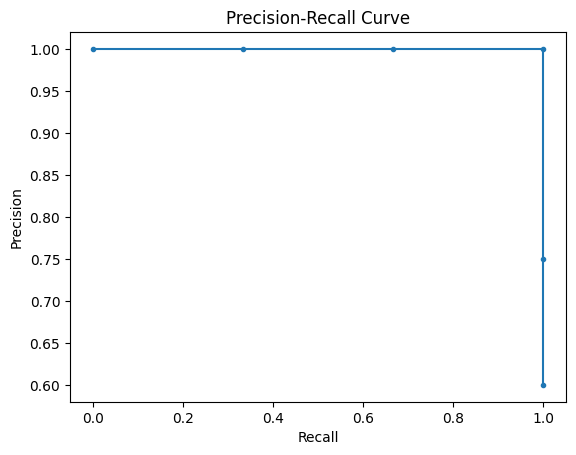

In [264]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Example: Replace these with your actual data
y_true = [0, 1, 1, 0, 1]  # Your true labels (binary: 0 or 1)
y_scores = [0.1, 0.9, 0.8, 0.2, 0.7]  # Your predicted probabilities for the positive class

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plot Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


#### Explanation 

predict Method:Both models output predicted probabilities for each class. For binary classification, focus on the probabilities for the positive class ([:, 1]).

precision_recall_curve:Computes precision and recall values at different thresholds for the predicted probabilities.

auc:Computes the Area Under the Precision-Recall Curve (AUC-PR), which provides a single metric summarizing the PR curve.

Plot:Precision is plotted on the y-axis and recall on the x-axis.

The AUC-PR score is displayed in the legend.

#### 5.Explore specific examples in which the model failed to predict correctly.

In [265]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Example data
y_true = [0, 1, 1, 0, 1, 0, 1, 0, 1, 0]  # True labels
y_pred = [0, 0, 1, 0, 1, 1, 1, 0, 0, 0]  # Predicted labels

# Convert to numpy arrays for easier manipulation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Identify misclassifications (where prediction does not match true label)
misclassified_indices = np.where(y_true != y_pred)[0]

# Extract misclassified samples
misclassified_samples = pd.DataFrame({
    'True Label': y_true[misclassified_indices],
    'Predicted Label': y_pred[misclassified_indices]
})

print("Misclassified Samples:")
print(misclassified_samples)

# Optionally, view more details on misclassifications (such as probabilities, feature values, etc.)
# For example, if you have predicted probabilities:
# y_scores = [0.1, 0.8, 0.9, 0.2, 0.7, 0.6, 0.85, 0.3, 0.4, 0.9]  # Predicted probabilities for positive class
# misclassified_probs = y_scores[misclassified_indices]
# misclassified_samples['Predicted Probability'] = misclassified_probs


Misclassified Samples:
   True Label  Predicted Label
0           1                0
1           0                1
2           1                0


#### Insights

Tough Cases: Do these pictures have features that are difficult to tell apart, like dogs laying in cat-like positions, or are they blurry?

Data Bias: Are the incorrectly classified photos in an under-represented category?

Model Restrictions: Does the model not work with certain backgrounds, lighting, or patterns?